In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'esgv' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980' # Updated 1/1/21
               , 'acy': '01/18/1998' # Updated 1/1/21
               , 'amd': '03/17/1980' # Updated 1/1/21
               , 'baba': '09/15/2014' # Updated 1/1/21
               , 'bac': '02/19/1973' # Updated 1/1/21
               , 'crm': '06/23/2004' # Updated 1/1/21
               , 'esgv': '09/16/2018' # Updated 1/1/21
               , 'goog': '08/16/2004'
               , 'ibm': '01/02/1962'
               , 'idex': '05/23/2007'
               , 'intc': '03/16/1980'
               , 'iyw': '05/15/2000'
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986'
               , 'nio': '09/10/2018'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'v': '03/16/2008'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,69.820000,69.519997,69.800003,69.820000,386400.0,69.581001,-0.000286,0.004315,0.007649,0.006027,4.367478e-03,-1
2020-12-18,69.820000,68.930000,69.779999,69.430000,587000.0,69.430000,0.005016,0.012912,-0.002170,0.006329,4.109083e-03,-1
2020-12-21,69.339996,68.129997,69.070000,69.239998,400100.0,69.239998,-0.002461,0.017760,-0.002737,0.006761,3.708280e-03,1
2020-12-22,69.570000,69.000000,69.570000,69.339996,369800.0,69.339996,0.003306,0.008261,0.001444,0.004194,1.358216e-03,-1
2020-12-23,69.690002,69.279999,69.660004,69.309998,286200.0,69.309998,0.005024,0.005918,-0.000433,0.004188,7.507633e-04,1
2020-12-24,69.580002,69.279999,69.550003,69.580002,140500.0,69.580002,-0.000431,0.004330,0.003896,0.002722,8.986090e-08,1
2020-12-28,70.110001,69.830002,70.000000,70.029999,281100.0,70.029999,-0.000429,0.004010,0.006467,0.003600,1.727586e-03,-1
2020-12-29,70.410004,69.629997,70.410004,69.809998,338500.0,69.809998,0.008522,0.011202,-0.003142,0.003728,1.646601e-03,1
2020-12-30,70.099998,69.820000,70.089996,69.910004,224000.0,69.910004,0.002568,0.004010,0.001433,0.003728,1.644264e-03,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.64241573 0.64241573 0.64241573]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

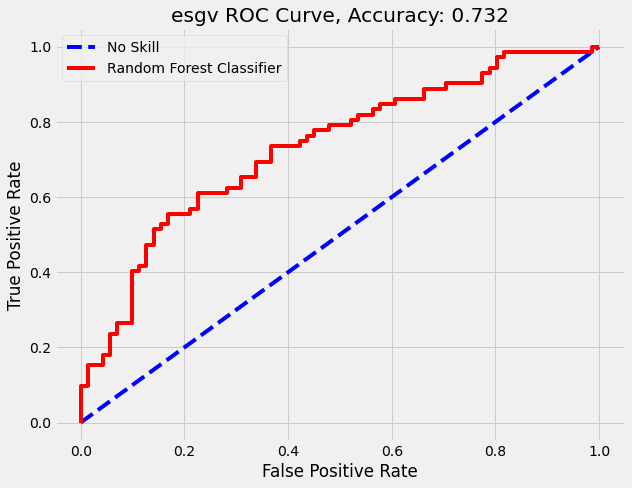

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

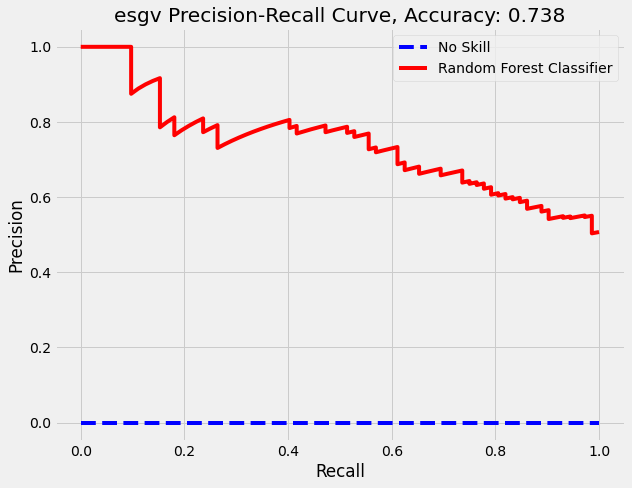

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

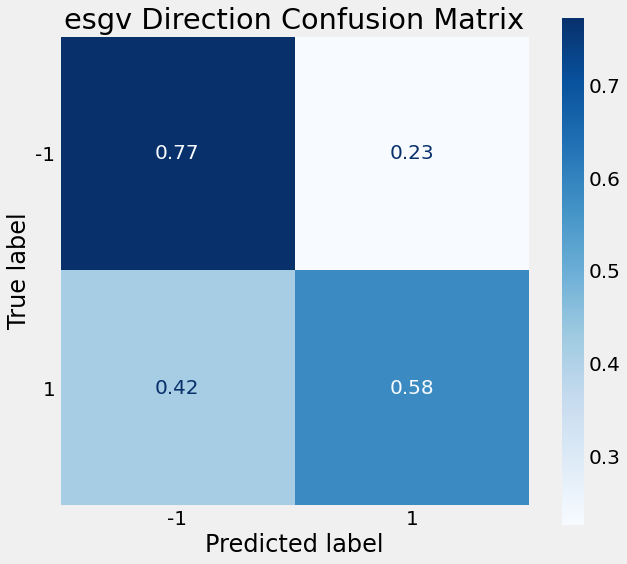

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.656140350877193'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High              70.290001
Low               69.739998
Open              69.940002
Close             70.169998
Volume        221900.000000
Adj Close         70.169998
oc                -0.003288
hl                 0.007886
adj                0.003719
5stdev_adj         0.003610
5sma_adj           0.002475
direction         -1.000000
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.003288
hl            0.007886
5stdev_adj    0.003610
5sma_adj      0.002475
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    570.000000
mean       0.000777
std        0.016125
min       -0.110297
25%       -0.004139
50%        0.001371
75%        0.008147
max        0.094159
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Sell or hold esgv


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,69.580002,69.279999,69.550003,69.580002,140500.0,69.580002,-0.000431,0.004330,0.003896,0.002722,8.986090e-08,1,-1,-0.006467
2020-12-28,70.110001,69.830002,70.000000,70.029999,281100.0,70.029999,-0.000429,0.004010,0.006467,0.003600,1.727586e-03,-1,-1,0.003142
2020-12-29,70.410004,69.629997,70.410004,69.809998,338500.0,69.809998,0.008522,0.011202,-0.003142,0.003728,1.646601e-03,1,1,0.001433
2020-12-30,70.099998,69.820000,70.089996,69.910004,224000.0,69.910004,0.002568,0.004010,0.001433,0.003728,1.644264e-03,1,-1,-0.003719
2020-12-31,70.290001,69.739998,69.940002,70.169998,221900.0,70.169998,-0.003288,0.007886,0.003719,0.003610,2.474589e-03,-1,-1,-0.001371


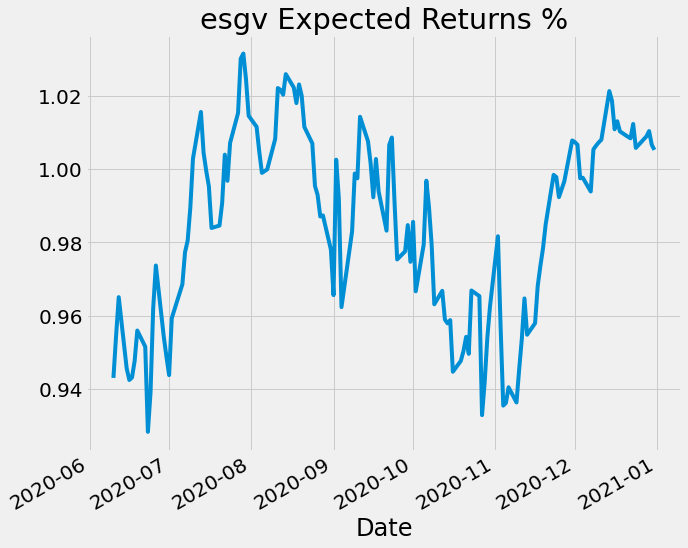

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

1.1197208117736985

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

0.37994100834942357

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/